In [19]:
import tensorflow as tf
import numpy as np
from functools import partial
from sklearn.datasets import load_sample_images
import matplotlib.pyplot as plt

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [13]:
# sample convolutional nn
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

c:\Projects\ml_tests\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [15]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 265s 143ms/step - accuracy: 0.6166 - loss: 1.0864 - val_accuracy: 0.8672 - val_loss: 0.3660
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 291s 169ms/step - accuracy: 0.8490 - loss: 0.4473 - val_accuracy: 0.8824 - val_loss: 0.3276
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 346s 183ms/step - accuracy: 0.8792 - loss: 0.3591 - val_accuracy: 0.9042 - val_loss: 0.2692
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 306s 178ms/step - accuracy: 0.8951 - loss: 0.3110 - val_accuracy: 0.8974 - val_loss: 0.3002
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 342s 199ms/step - accuracy: 0.9002 - loss: 0.2900 - val_accuracy: 0.9116 - val_loss: 0.2496


ResNet-34

In [3]:
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal', use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]
        
        def call(self, inputs):
            Z = inputs
            for layer in self.main_layers:
                Z = layer(Z)
            skip_Z = inputs
            for layer in self.skip_layers:
                skip_Z = layer(skip_Z)
            return self.activation(Z + skip_Z)

In [4]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224,3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation='softmax'))

c:\Projects\ml_tests\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


c:\Projects\ml_tests\venv\Lib\site-packages\keras\src\layers\layer.py:1331: UserWarning: Layer 'residual_unit' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''Layer ResidualUnit does not have a `call()` method implemented.''
  warnings.warn(
c:\Projects\ml_tests\venv\Lib\site-packages\keras\src\layers\layer.py:372: UserWarning: `build()` was called on layer 'residual_unit', however the layer does not have a `build()` method implemented and it looks like it ha

Pretrained models

In [13]:
images = load_sample_images()["images"]
images = np.array(images)
images.shape

(2, 427, 640, 3)

In [16]:
resize_layer = tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True)
images_resized = np.array([resize_layer(image) for image in images])
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)

In [7]:
model = tf.keras.applications.ResNet50(weights='imagenet')

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 74s 1us/step


In [17]:
Y_proba = model.predict(inputs)
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f'Obraz numer {image_index}')
    for class_id, name, y_proba in top_K[image_index]:
        print(f'    {class_id} - {name:12s} {y_proba:.2%}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Obraz numer 0
    n03877845 - palace       54.23%
    n03781244 - monastery    24.55%
    n02825657 - bell_cote    19.08%
Obraz numer 1
    n04522168 - vase         33.40%
    n11939491 - daisy        17.54%
    n03530642 - honeycomb    11.60%


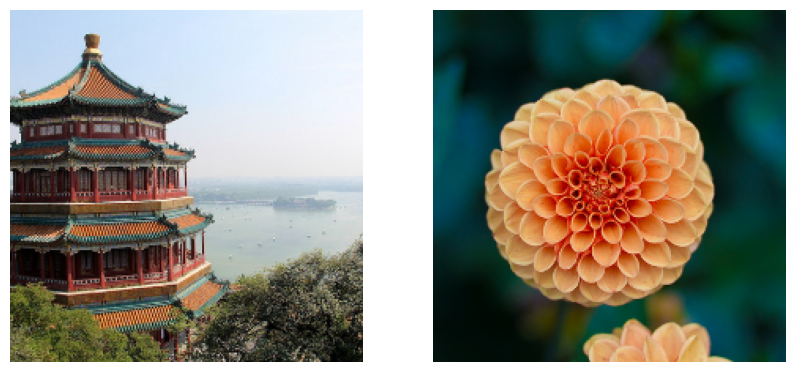

In [20]:
plt.figure(figsize=(10, 6))
for idx in (0, 1):
    plt.subplot(1, 2, idx + 1)
    plt.imshow(images_resized[idx] / 255)
    plt.axis("off")

plt.show()